In [368]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scienceplots
plt.style.use(['science'])

In [369]:
def g(t,tau):
    return np.exp(-2*np.log(2)*t**2/tau**2)

def exp_decay(t,T2,c):
    return -t/T2+c

def CARS(t_arr, floor, A1, A2, T21, T22, del_om1, del_om2, tau = 200e-15, dt = 20e-15):
    theta_arr = np.arange(-5*tau, 5*tau, dt)
    Q = np.array([np.trapezoid((A1*np.exp(-(t-theta_arr)/T21+1j*del_om1*(t-theta_arr))+A2*np.exp(-(t-theta_arr)/T22+1j*del_om2*(t-theta_arr)))*np.heaviside(t-theta_arr,1)*g(theta_arr,tau)**2, theta_arr) for t in t_arr])
    S = np.array([np.trapezoid(np.abs(Q)**2 * g(t_arr-t, tau),t_arr) for t in t_arr])+floor
    return S

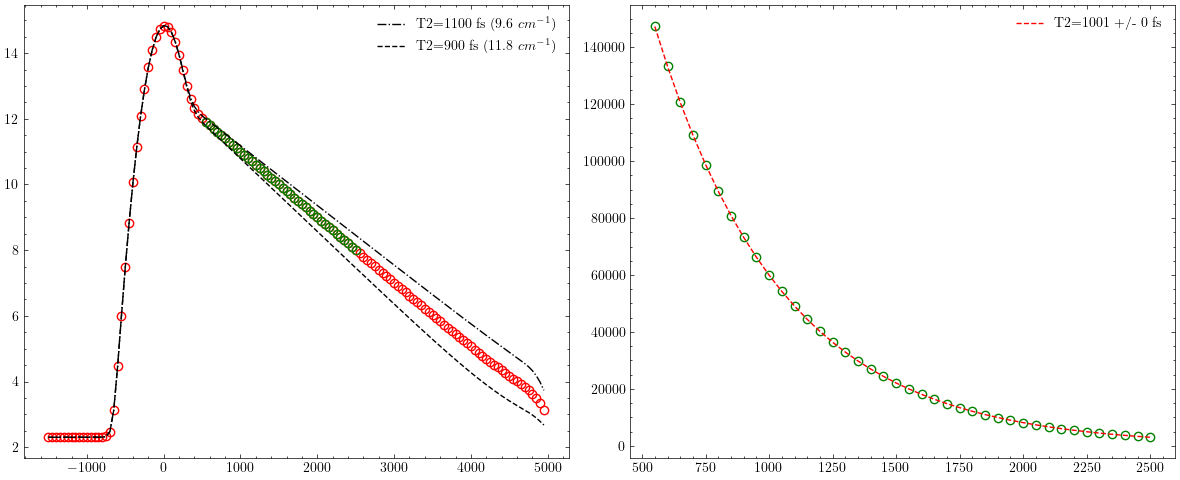

In [397]:
nuR_tuned = 850
nuR1, nuR2 = 700, 1000
T21, T22 = 1000e-15, 1500e-15
tau = 200e-15
A1, A2 = 1e23, 0
floor = 10
dt = 50e-15
T2_perc = 0.10
del_om1, del_om2 = 2*np.pi*(nuR1-nuR_tuned)*3e10, 2*np.pi*(nuR2-nuR_tuned)*3e10
t_arr = np.arange(-1500e-15, 5000e-15, dt)
S = CARS(t_arr, floor, A1, A2, T21, T22, del_om1, del_om2)
#S = np.abs(Q)**2+10

S_log = np.log(S)
#DONT SCALE IN LOG!!!
#S_log = (S_log-np.min(S_log))/(np.max(S_log)-np.min(S_log))
t_fs = t_arr*1e15

fig,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(t_fs,S_log, 'ro', mfc='none')

#selected data range
td1,td2 = 500, 2500
rng = (t_fs>td1) & (t_fs<td2)
ax[0].plot(t_fs[rng],S_log[rng], 'go', mfc='none')

#fit def exp_decay(t,m,c):
popt,pcov = curve_fit(exp_decay, t_fs[rng], S_log[rng])
ax[0].plot(t_fs, np.log(CARS(t_arr, floor, A1, A2, T21*(1+T2_perc), T22, del_om1, del_om2)), 'k-.',label=f'T2={T21*1e15*(1+T2_perc):.0f} fs ({1/np.pi/3e10/(T21*(1+T2_perc)):.1f} '+r'$cm^{-1}$)')
ax[0].plot(t_fs, np.log(CARS(t_arr, floor, A1, A2, T21*(1-T2_perc), T22, del_om1, del_om2)), 'k--',label=f'T2={T21*1e15*(1-T2_perc):.0f} fs ({1/np.pi/3e10/(T21*(1-T2_perc)):.1f} '+r'$cm^{-1}$)')
ax[0].legend()

ax[1].plot(t_fs[rng], np.exp(S_log[rng]),'go', mfc='none')
ax[1].plot(t_fs[rng], np.exp(exp_decay(t_fs[rng], *popt)),'r--',label=f'T2={2*popt[0]:.0f} +/- {2*pcov[0,0]**2:.0f} fs')
ax[1].legend()

plt.tight_layout()